## 1. Create a dataset of several stock prices downloaded directly from Yahoo Finance

In [1]:
# Choose the assets that will be included in the dataset
stocks <- c("AAPL", "AMZN", "MSFT", "GOOGL", "BRK-A", "JPM")
datalist <- list() 
t1 <- as.integer(ISOdate(2010,1,17,hour=0))
t2 <- as.integer(ISOdate(2022,2,17,hour=0))

for (stock in stocks) {
    url <- paste("https://query1.finance.yahoo.com/v7/finance/download/",
                 stock,
                 "?period1=",
                 as.integer(t1),
                 "&period2=",
                 as.integer(t2),
                 "&interval=1d&events=history&includeAdjustedClose=true",
                 sep="")
    data <- read.csv(url)
    data['Date'] <- as.Date(data$Date)    
    datalist[[stock]] <- data.frame(date=data$Date,price=data$Adj.Close)
}

# Merge
prices <- data.frame(datalist$AAPL)
colnames(prices) <- c('date','AAPL')
for (i in 2:length(datalist)) {
    temp <- datalist[[i]]
    colnames(temp) <- c('date', stocks[i])
    prices <- merge(prices,temp,by="date")
}
prices <- data.frame(prices)
tail(prices)

,date,AAPL,AMZN,MSFT,GOOGL,BRK.A,JPM
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3038,2022-02-09,176.28,3223.79,310.5678,2831.84,483900,156.60
3039,2022-02-10,172.12,3180.07,301.7561,2772.40,480105,155.95
3040,2022-02-11,168.64,3065.87,294.4312,2685.65,479370,153.92
3041,2022-02-14,168.88,3103.34,294.3913,2710.52,472410,152.49
3042,2022-02-15,172.79,3130.21,299.8500,2732.17,473980,154.72
3043,2022-02-16,172.55,3162.01,299.5000,2754.76,474444,155.00


## 2. Generate log-returns
Let $P_{i,t}$ denote the price of stock $i$ at date $t$. Hence, the log-return of stock $i$ at date $t$ would given by $$R_{i,t} = \log\left(\frac{P_{i,t}}{P_{i,t-1}}\right)$$

In [2]:
# compute log-returns
genretdf <- function(pricesdf, nonans = TRUE) {
  prices <- data.matrix(pricesdf)
  ret <- 100*(diff(log(prices[,2:ncol(prices)])))  
  TT <- nrow(ret)
  pricesdf <- pricesdf[1:TT+1,]
  date <- as.Date(pricesdf$date) 
  retdf <- data.frame(date,ret)
  if (nonans==TRUE){
    retdf <- na.omit(retdf) 
  }
  return(retdf)
}

retdf <- genretdf(prices, nonans=TRUE)
tail(retdf)

,date,AAPL,AMZN,MSFT,GOOGL,BRK.A,JPM
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3037,2022-02-09,0.8259550,-0.1388698,2.15997589,1.5609396,0.38719210,0.4159398
3038,2022-02-10,-2.3881755,-1.3654468,-2.87832815,-2.1213372,-0.78734438,-0.4159398
3039,2022-02-11,-2.0425619,-3.6571813,-2.45735821,-3.1790588,-0.15320882,-1.3102450
3040,2022-02-14,0.1422174,1.2147562,-0.01355825,0.9217758,-1.46254892,-0.9333921
3041,2022-02-15,2.2888511,0.8621103,1.83725484,0.7955631,0.33178741,1.4517985
3042,2022-02-16,-0.1389877,1.0107822,-0.11679521,0.8234191,0.09784654,0.1808079


## 3. Margins
A GJR-GARCH(1,1,1) model with Hansen's (1994) skewed-t errors is used for margins, i.e., we assume that
\begin{eqnarray} 
R_{i,t} &=& \mu_i + \sigma_{i,t} Z_{i,t} \\ 
\sigma_{i,t}^2 &=&  \omega + \beta  \sigma_{i,t-1}^2 + \alpha (\sigma_{i,t-1} z_{i,t-1})^2 + \gamma (\sigma_{i,t-1} z_{i,t-1})^2 I_{\{z_{i,t-1}<0\}}
\end{eqnarray}

where:

* $Z_{i,t}$ is an i.i.d. random variable that follows a skewed-t of Hansen (1994) distribution, with degrees of freedom and asymmetry parameters denoted by $2<\nu<\infty$ and $-1<\eta<1$, respectively. 
* $\mu_i$ denotes de unconditional mean
* $I$ is an indicator function that takes the value of 1 if the inequality is satisfied and 0 otherwise.
* Positiveness restrictions: $\omega>0$, and $\alpha,\beta,\gamma \geq 0$
* Stationarity restriction:  $\gamma < 2(1-\alpha-\beta)$

Notice that for each asset return $i\in\{1,...,d\}$, there are 7 parameters to be estimated $$\theta_i=(\mu_i, \omega_i, \beta_i, \alpha_i, \gamma_i,\nu_i,\eta_i)$$

In [3]:
GJRGARCHloglik <- function(par, ret) {
  # Mean: unconditional mean
  # Error's distribution: skewed-t of Hansen (1994)  
  TT <- length(ret)
  
  # Starting values:
  rbar <- mean(ret)
  condVar <- matrix(rep(0,TT),TT)
  epsi <- matrix(rep(0,TT),TT)
  z <- matrix(rep(0,TT),TT)
  condVar[1] <- mean((ret-rbar)^2)
  epsi[1] <- sqrt(condVar[1])
  z[1] <- 1
  
  # Unconditional mean:
  mu <- par[1]
  
  # Conditional variance:
  # sigma_{t}^2 = omega + beta*sigma_{t-1}^2 + alpha*epsilon_{t-1}^2 + gamma*epsilon{t-1}^2*ind{z_{t-1}<0}
  b0 <- par[2] # omega
  b1 <- par[3] # beta
  b2 <- par[4] # alpha
  b3 <- par[5] # gamma
    
  # GJR-GARCH(1,1) :
  for (t in 2 : TT)  {
    condVar[t] <-  b0 + b1*condVar[t-1] + b2*epsi[t-1]^2 + b3*min(epsi[t-1],0)^2 # GJR-GARCH(1,1) 
    z[t] <- (ret[t]-mu)/sqrt(condVar[t])   
    epsi[t] <- z[t]*sqrt(condVar[t]) 
  }
    sigmaPrime <- sqrt( b0 + b1*tail(condVar,1) + b2*tail(epsi,1)^2 + b3*min(tail(epsi,1),0)^2 )

  # Skewed-t shape parameters:
    a <- tail(par,2) 
    nu <- a[1] # degrees of freedom
    lambda <- a[2] # skewnes parameter
  
  
  # Log-likelihood
  logc <- lgamma((nu+1)/2) - lgamma(nu/2) - log(sqrt(pi*(nu-2))) 
  c = exp(logc) 
  a <- 4*lambda*c*((nu-2)/(nu-1))
  logb <- 0.5*log(1 + 3*lambda^2 - a^2)
  b <- exp(logb)
  f1 <- which(z <  (-a/b))
  f2 <- which(z >= (-a/b))
  ll <- rep(NaN,length(z))
  ll1 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f1]+a)/(1-lambda))^2 ) - 0.5*log(condVar[f1])
  ll2 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f2]+a)/(1+lambda))^2 ) - 0.5*log(condVar[f2])
  ll[f1] <- ll1
  ll[f2] <- ll2 
  LL <- -sum(ll)
  return(LL)
}

In [4]:
# Estimate GJR-GARCH parameters by Maximum Likelihood for each asset:
#install.packages("pracma", repos="http://R-Forge.R-project.org")
#install.packages("NlcOptim")
library(pracma)

par1 <- NULL
se1 <- NULL
gofind1 <- NULL

for (i in names(retdf[,2:ncol(retdf)])){ 
  ret <- retdf[,i]
  mu0 <- mean(ret)
  omega0 <- 0.01 ; beta0 <- 0.87 ; alpha0 <- 0.08 ; gamma0 <- 0.09
  nu0 <- 4 ; lambda0 <- - 0.2
  par0 <- c(mu0, omega0, beta0, alpha0, gamma0, nu0, lambda0) 
  
  lb <- c(-100, rep(0.00001,3), -1, 2.01, -0.99) # lower bounds for GARCH(1,1) parameters: [mu, omega(>0), beta(>0), alpha(>0), gamma(=>0), nu(>2), lambda > -0.99]
  ub <- c(rep(100,6), 0.99)                      # upper bounds for GARCH(1,1) parameters: [mu, omega, beta, alpha, gamma, nu, lamnda < 0.99]
  A  <- matrix(rbind(c(0, 0, 1, 1, 0.5, 0, 0), c(0, 0, 0, -1, -1, 0, 0)), 2)   # alpha + beta + 0.5*gamma < 1
  b  <- matrix(c(0.999, -0.0001),2)    
  Aeq  <- NULL
  beq  <- NULL
  x1 <- fmincon(x0 = par0, 
                ret = ret, 
                GJRGARCHloglik, # objective function
                ub=ub, lb=lb, 
                A=A, b=b, 
                Aeq=Aeq, beq=beq, tol=1e-05)
  par0 <- x1$par
  par1 <- rbind(par1,par0)
  hessianMatrix <- hessian(GJRGARCHloglik, x1$par, ret=ret)
  se0 <- sqrt(diag(inv(hessianMatrix)))
  se1 <- rbind(se1,se0)
  LogLik <- - x1$value 
  AIC <- 2*length(par0) - 2*LogLik 
  BIC <- length(par0)*log(nrow(retdf)) - 2*LogLik 
  gofind0 <- c(LogLik,AIC,BIC)
  gofind1 <- rbind(gofind1,gofind0)
}

In [5]:
# Estimated parameters
estimates <- data.frame(par1) 
colnames(estimates) <- c("mu","omega","beta","alpha","gamma","nu","lambda")
rownames(estimates) <- names(retdf[,2:ncol(retdf)])
estimates_df <- data.frame(estimates)
estimates_df

,mu,omega,beta,alpha,gamma,nu,lambda
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAPL,0.12978456,0.16638269,0.8358643,0.031445057,0.1669698,4.848339,-0.019005617
AMZN,0.10249794,0.23998371,0.8435992,0.019162569,0.1693960,4.132809,-0.017242687
MSFT,0.07979434,0.10945665,0.8515873,0.028103678,0.1634684,4.664144,-0.014706796
GOOGL,0.06547301,0.12138401,0.8859604,0.004658668,0.1374024,3.789469,-0.056483643
BRK.A,0.04130865,0.04861687,0.8530933,0.040133560,0.1460449,5.883985,0.019962553
JPM,0.06076088,0.06955445,0.8830088,0.026204536,0.1391227,5.631539,-0.005292219


In [6]:
# Standard errors 
se <- data.frame(se1) 
colnames(se) <- c("mu","omega","beta","alpha","gamma","nu","lambda")
rownames(se) <- names(retdf[,2:ncol(retdf)])
se_df <- data.frame(se)
se_df

,mu,omega,beta,alpha,gamma,nu,lambda
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAPL,0.02669875,0.03357637,0.02204078,0.013600338,0.03068413,0.4280348,0.02508542
AMZN,0.03019704,0.05854105,0.02785222,0.012670445,0.03441793,0.3059433,0.02508477
MSFT,0.02318247,0.02506648,0.02283992,0.013927841,0.03161761,0.3879476,0.02453275
GOOGL,0.02483539,0.03262030,0.02187649,0.005699395,0.02828755,0.2707505,0.02438474
BRK.A,0.01661818,0.01115900,0.02240678,0.014363485,0.02790487,0.5970030,0.02506898
JPM,0.02389219,0.01709268,0.01830425,0.011164942,0.02494933,0.5553657,0.02528896


In [7]:
# AIC, BIC and log-likelihood 
gof_df <- data.frame(gofind1)
colnames(gof_df) <- c("log-likelihood","AIC","BIC")
rownames(gof_df) <- names(retdf[,2:ncol(retdf)])
gof_df

,log-likelihood,AIC,BIC
,<dbl>,<dbl>,<dbl>
AAPL,-5631.737,11277.474,11319.62
AMZN,-5969.654,11953.308,11995.45
MSFT,-5217.575,10449.149,10491.29
GOOGL,-5313.323,10640.647,10682.79
BRK.A,-4275.199,8564.398,8606.54
JPM,-5435.947,10885.894,10928.04


Visualize how log-returns, $R_t$ and standardized returns, $Z_t$ look like:

In [8]:
GJRGARCHoutputs <- function(par, ret) {
  # Conditional volatility: GJR-GARCH(1,1,1)
  # Mean: unconditional mean
  # Error distribution: Skewed-t of Hansen (1994) 
  TT <- length(ret)
  
  # Starting values:
  rbar <- mean(ret)
  condVar <- matrix(rep(0,TT),TT)
  epsi <- matrix(rep(0,TT),TT)
  z <- matrix(rep(0,TT),TT)
  condVar[1] <- mean((ret-rbar)^2)
  epsi[1] <- sqrt(condVar[1])
  z[1] <- 1
  
  # Unconditional mean:
  mu <- par[1]
  
  # Conditional variance:
  # sigma_{t}^2 = omega + beta*sigma_{t-1}^2 + alpha*epsilon_{t-1}^2 + gamma*epsilon{t-1}^2*ind{z_{t-1}<0}
  b0 <- par[2] # omega
  b1 <- par[3] # beta
  b2 <- par[4] # alpha
  b3 <- par[5] # gamma
    
  # GJR-GARCH(1,1) :
  for (t in 2 : TT)  {
  condVar[t] <-  b0 + b1*condVar[t-1] + b2*epsi[t-1]^2 + b3*min(epsi[t-1],0)^2 # GJR-GARCH(1,1) 
  z[t] <- (ret[t]-mu)/sqrt(condVar[t])   
  epsi[t] <- z[t]*sqrt(condVar[t]) 
  }
  sigmaPrime <- sqrt( b0 + b1*tail(condVar,1) + b2*tail(epsi,1)^2 + b3*min(tail(epsi,1),0)^2 )
 
  # Distribution parameters:
  a <- tail(par,2) 
  nu <- a[1] # degrees of freedom
  lambda <- a[2] # skewnes parameter

  # Output
  out <- list(z=z,condVar=condVar,sigmaPrime=sigmaPrime)
  return(out)
}

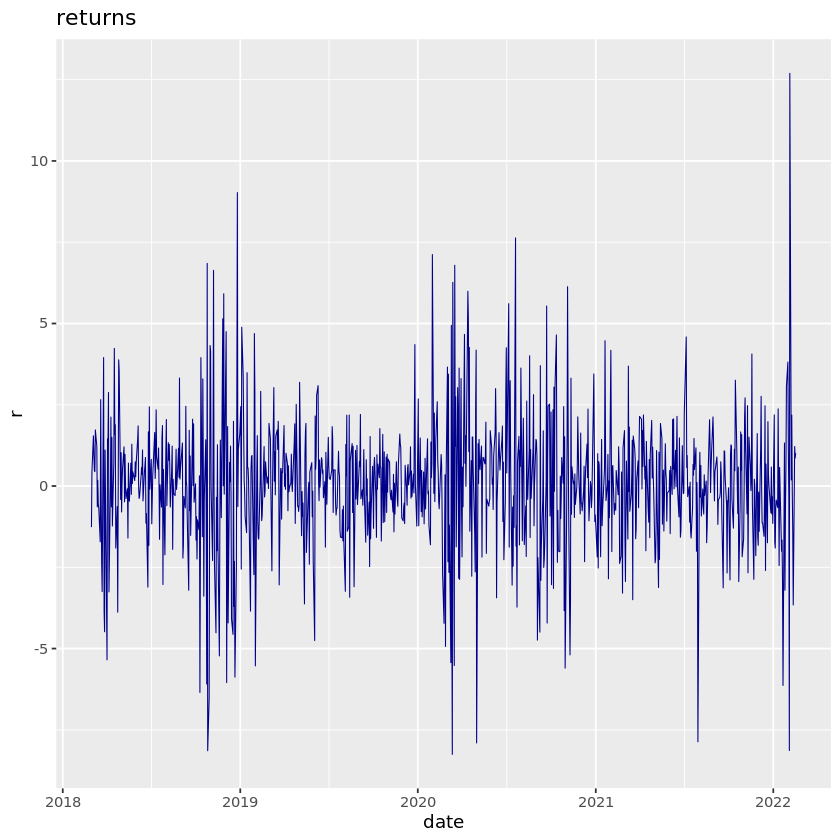

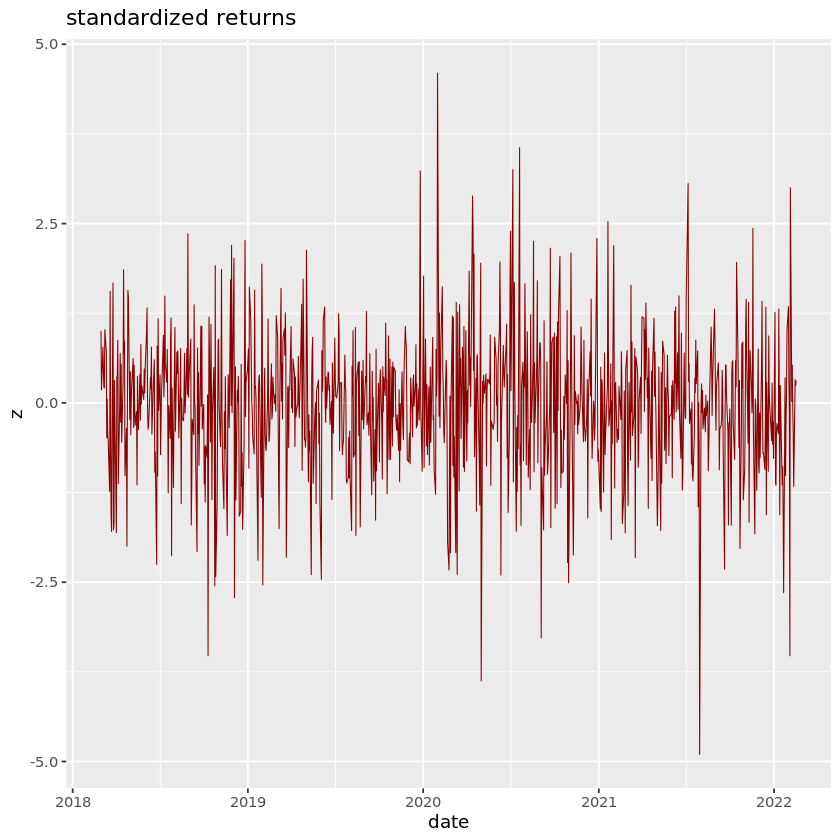

In [9]:
library(ggplot2)

# Choose an asset:
asset <- "AMZN"
estPeriod <- 1000 # days

out <- GJRGARCHoutputs(par=as.matrix(estimates_df["AMZN",]), ret=as.matrix(tail(retdf[asset],estPeriod))) 

plotdf <- data.frame(tail(retdf[,"date"],estPeriod), tail(retdf[asset],estPeriod), out$z)
                       
names(plotdf) <- c("date","r","z")
rplot <- ggplot(plotdf, aes(x = date)) + 
  geom_line(aes(y = r), size = 0.3, color = "darkblue") +
  labs(title = "returns", 
       #subtitle = print("Total sample"),
       x = "date",
       y = "r" )

zplot <- ggplot(plotdf, aes(x = date)) + 
  geom_line(aes(y = z), size = 0.3, color = "darkred") +
  labs(title = "standardized returns", 
       #subtitle = print("Total sample"),
       x = "date",
       y = "z" )

rplot
zplot

In [10]:
 summary(plotdf[,2:3])

       r                  z           
 Min.   :-8.25350   Min.   :-4.90041  
 1st Qu.:-0.86429   1st Qu.:-0.54249  
 Median : 0.13235   Median : 0.01696  
 Mean   : 0.07375   Mean   :-0.02156  
 3rd Qu.: 1.09074   3rd Qu.: 0.50788  
 Max.   :12.69490   Max.   : 4.59463  

## 4. Dependence structure (C-Vine copula)
### 4.1. Dependent uniforms
Copula model input is $V_{i,t} = F(Z_{i,t})$, $i=1,2,3,...,d$.

In [11]:
# Skewed-t CDF
skewtcdf <- function(x, nu, lambda) {
  # Compute the Hansen's skewed-t CDF
  # USAGE:
  #   P = skewtcdf(X,NU,LAMBDA)
  
  # INPUTS:
  #   X      - Standardized T random variables, either scalar or column vector
  #   nu     - Degree of freedom parameter (scalar)
  #   lambda - Degree of freedom parameter (scalar) 
  
  # OUTPUTS:
  #   P      - Cumulative distribution evaluated at x
  
  # COMMENTS:
  #   nu > 2
  #   -.99 < lambda < .99  
  
  # REFERENCE:
  #   [1] Hansen (1994), Intl.Econ.Rev. (35)
  
  c <- gamma((nu+1)/2)/(sqrt(pi*(nu-2))*gamma(nu/2))
  a <- 4*lambda*c*((nu-2)/(nu-1))
  b <- sqrt(1 + 3*lambda^2 - a^2)
  
  f1 <- which(x <  -a/b)
  f2 <- which(x >= -a/b)
  
  y1 <- (b*x+a)/(1-lambda)*sqrt(nu/(nu-2))  
  y2 <- (b*x+a)/(1+lambda)*sqrt(nu/(nu-2)) 
  
  p = rep(NaN,length(x))
  p[f1] <- (1-lambda)*pt(y1[f1], nu, lower.tail = TRUE, log.p = FALSE)
  p[f2] <- ((1-lambda)/2  + (1+lambda)*(pt(y2[f2], nu, lower.tail = TRUE, log.p = FALSE)-0.5))
  
  return(p) 
} 

In [12]:
marginparnames <- c("mu","omega","beta","alpha","gamma","nu","lambda")
v <- list()
d <- 6 # portfolio dimension (number of stocks)
dd <- d + 1

for (i in names(retdf[,2:dd])){
  par0 <- as.matrix(estimates_df[i,])
  ret <- as.matrix(retdf[,i])
  out <- GJRGARCHoutputs(par=as.numeric(par0), ret=ret) 
  z <- as.matrix(out$z)
  v[[i]] <- skewtcdf(z, as.numeric(par0[i,"nu"]), as.numeric(par0[i,"lambda"]))
}

vdata <- matrix(rep(NaN,d*nrow(retdf)), nrow(retdf))
colnames(vdata) <- names(retdf[,2:dd]) 
for (i in names(retdf[,2:dd])) {
  vdata[,i] <- v[[i]]
}
 
print(summary(vdata)) # vdata represent probabilities

head(vdata)

      AAPL                AMZN                MSFT          
 Min.   :0.0002077   Min.   :0.0003202   Min.   :0.0000492  
 1st Qu.:0.2590248   1st Qu.:0.2448354   1st Qu.:0.2534870  
 Median :0.4840546   Median :0.4967906   Median :0.4931600  
 Mean   :0.4977838   Mean   :0.4994360   Mean   :0.5001562  
 3rd Qu.:0.7536046   3rd Qu.:0.7544292   3rd Qu.:0.7540474  
 Max.   :0.9996391   Max.   :0.9999184   Max.   :0.9999257  
     GOOGL               BRK.A                JPM           
 Min.   :0.0004261   Min.   :0.0001616   Min.   :0.0001879  
 1st Qu.:0.2528913   1st Qu.:0.2524948   1st Qu.:0.2526711  
 Median :0.4934996   Median :0.5001526   Median :0.4938436  
 Mean   :0.5001247   Mean   :0.5015749   Mean   :0.4992113  
 3rd Qu.:0.7507280   3rd Qu.:0.7497685   3rd Qu.:0.7506260  
 Max.   :0.9999627   Max.   :0.9998938   Max.   :0.9998087  


AAPL,AMZN,MSFT,GOOGL,BRK.A,JPM
0.875343094,0.88353604,0.87700127,0.890792842,0.866838578,0.868976083
0.106398931,0.64646370,0.07475847,0.614357488,0.997933435,0.001563414
0.007320795,0.01499815,0.01984517,0.003420097,0.008790666,0.114179655
0.847079242,0.29909766,0.73385424,0.178976315,0.163804868,0.508293587
0.714655145,0.33311324,0.62050755,0.564287173,0.208601817,0.228064910
0.650333472,0.90550244,0.61958515,0.458723885,0.988085041,0.794831934


### 4.2. C-Vine copula parameters' estimation

In [13]:
#install.packages("VineCopula")
library(VineCopula)
CVineStruct <- RVineStructureSelect(data=vdata, familyset = NA, type="CVine",
                                      selectioncrit = "BIC",
                                      indeptest = TRUE, level = 0.05,
                                      trunclevel = NA, progress = FALSE,
                                      weights = NA,
                                      treecrit = "tau",
                                      rotations = TRUE,
                                      se = FALSE,
                                      presel = FALSE,
                                      method = "mle",
                                      cores = 1)

In [14]:
# Let's take a look to the C-Vine structure:
CVineStruct  

C-vine copula with the following pair-copulas:
Tree 1:
4,2  t (par = 0.63, par2 = 4.87, tau = 0.44) 
4,1  Survival Gumbel (par = 1.53, tau = 0.35) 
4,3  t (par = 0.61, par2 = 4.06, tau = 0.42) 
4,5  Survival Gumbel (par = 1.39, tau = 0.28) 
6,4  Survival Gumbel (par = 1.36, tau = 0.27) 

Tree 2:
5,2;4  Survival BB8 (par = 1.48, par2 = 0.77, tau = 0.09) 
5,1;4  Frank (par = 1.14, tau = 0.13) 
5,3;4  Frank (par = 1.5, tau = 0.16) 
6,5;4  t (par = 0.6, par2 = 8.89, tau = 0.41) 

Tree 3:
3,2;5,4  Survival BB8 (par = 2.26, par2 = 0.67, tau = 0.17) 
3,1;5,4  Survival BB8 (par = 2.35, par2 = 0.66, tau = 0.18) 
6,3;5,4  t (par = 0.08, par2 = 14.39, tau = 0.05) 

Tree 4:
1,2;3,5,4  Frank (par = 0.94, tau = 0.1) 
6,1;3,5,4  Frank (par = 0.41, tau = 0.05) 

Tree 5:
6,2;1,3,5,4  Independence 

---
1 <-> AAPL,   2 <-> AMZN,   3 <-> MSFT,
4 <-> GOOGL,   5 <-> BRK.A,   6 <-> JPM

## 5. Portfolio optimization
Let define the portfolio return by $$R_p(\mathbf{w}) = \sum_{i=1}^{d}w_i R_i,$$ were $\mathbf{w}=(w_1,...,w_d)'$, $w_1 + ... + w_d = 1$ and $w_i \in [0,1]$ for $i=1,2,...,d$. The portfolio expected shortfall at coverage level $\alpha$ is given by $$ ES_\alpha(R_p)=\mathbb{E}(R_p(\mathbf{w})|R_p(\mathbf{w})<q_\alpha),$$ where $\alpha \in(0,1)$ and $q_\alpha$ denotes the $\alpha$-quantile of $R_p$.

According to Rockafellar and Uryasev (2000), the optimal portfolio allocation corresponds to the vector of weights $\mathbf{w}=(w_1,...,w_d)'$ that solves the following problem: 
 $$\left.  \begin{array}{c}
 \min_{\mathbf{w}} - ES_{\alpha}(w_1 R_1 + ... + w_d R_d)  \\ 
 \text{s.t.} 
 \left\{ 
 \begin{array}{c}
 w_1 \geq 0,..., w_d \geq 0 \\
 w_1 + ... + w_d = 1 \\
 w_1 \mu_1 + ... + w_d\mu_d = r_0
 \end{array} \right.
 \end{array} \right\}$$
 
That is, we choose the portfolio allocation in such a way that market risk (measured by the ES) is minimized and $r_0$ is an investor's decision. The portfolio allocation that minimizes risk without considering $r_0$ is called global minimum wisk (GMR) portfolio.

In [15]:
N = 100000 
alpha = 0.05 # coverage level for expected shortfall
w <- matrix(rep(NaN,d),1)

In [16]:
# Simulate dependent uniforms, v, from the copula
CVinePar <- CVineStruct
CVM <- RVineMatrix(Matrix = CVinePar$Matrix, family = CVinePar$family,
                     par = CVinePar$par, par2 = CVinePar$par2,
                     names=names(retdf[,2:dd]))

vdata <- RVineSim(N, CVM, U = NULL)

In [17]:
# Skewed-t inverse
skewtinv <- function(p, nu, lambda) {
  # USAGE:
  #   X=skewtinv(P,V,LAMBDA)
  
  # INPUTS:
  #   P      - Values to be inverted, P in [0,1]
  #   nu     - Degree of freedom parameter (scalar)
  #   lambda - Degree of freedom parameter (scalar) 
  
  # OUTPUTS:
  #   X      - Skewed T distributed random variables corresponding to P
  
  # COMMENTS:
  #   nu > 2
  #   -.99 < lambda < .99  
  
  # REFERENCE:
  #   [1] Hansen (1994), Intl.Econ.Rev. (35)
  
  c <- gamma((nu+1)/2)/(sqrt(pi*(nu-2))*gamma(nu/2))
  a <- 4*lambda*c*((nu-2)/(nu-1))
  b <- sqrt(1 + 3*lambda^2 - a^2)
  
  f1 <- which(p <  (1-lambda)/2)
  f2 <- which(p >= (1-lambda)/2)
  
  inv1 <- ((1-lambda)/b)*sqrt((nu-2)/nu)*qt(p[f1]/(1-lambda),nu) - a/b
  inv2 <- ((1+lambda)/b)*sqrt((nu-2)/nu)*qt(0.5+1/(1+lambda)*(p[f2]-(1-lambda)/2),nu) - a/b
  
  x <- rep(NaN,length(p))
  x[f1] <- inv1
  x[f2] <- inv2
  return(x) 
}  

In [18]:
# Recover z by using the fact that z = F^(-1)(v) 
zdata <- matrix(rep(NaN,N*d),N)
colnames(zdata) <- names(retdf[,2:dd])
for (i in names(retdf[,2:dd])){
  zdata[,i] <- skewtinv(vdata[,i],as.numeric(estimates_df[i,"nu"]),as.numeric(estimates_df[i,"lambda"]))
}

In [19]:
# Recover r by using the fact that r = mu + ht*z
rdata <- matrix(rep(NaN,N*d),N)
colnames(rdata) <- names(retdf[,2:dd])
for (i in names(retdf[,2:dd])){
  par0 <- as.numeric(estimates_df[i,])
  ret <- as.numeric(retdf[,i])
  out <- GJRGARCHoutputs(par=as.numeric(par0), ret=ret) 
  ht <- as.numeric(out$sigmaPrime)
  rdata[,i] <- estimates_df[i,"mu"] + sqrt(ht)*zdata[,i]
}

In [20]:
# Objective function (expected shortfall)
ES_RockafellarUryasev2000 <- function(x0, rdata, alpha) {
  m = ncol(rdata)
  v = x0[1]
  w = matrix(x0[1:m+1])
  rp = t(w)%*%t(rdata)
  di = pmax(0, v-rp)
  ES = - (1/alpha)*mean(di) + v
  ES = - ES
  return(ES)
}

In [21]:
# Non-linear optimization
# Starting values: 
v0 <- -0.1
w0 <- rep(1,d)*(1/d)  
x0 <- matrix(c(v0,w0),1)

# Optimization restrictions:
lb <- c(-100, rep(0,d))  # lower bounds for x = (v,w1, ... ,wm)
ub <- c( 100, rep(1,d))  # upper bounds for x = (v,w1, ... ,wm)
A  <- - matrix(c(0, estimates_df[ ,"mu"]),1)
b  <- - min(estimates_df[ ,"mu"])  
Aeq  <- matrix(c(0, rep(1,d)),1) 
beq   <- 1 

# Global minimum risk portfolio:
x1 <- fmincon(x0=x0,
              rdata=rdata,
              alpha=alpha,
              ES_RockafellarUryasev2000,
              ub=ub,
              lb=lb,
              A=A,
              b=b,
              Aeq=Aeq,
              beq=beq,
              tol = 1e-05)

# Final value  
ES <- - x1$value 

# Variables final values
xw <- x1$par
w <- tail(xw, d) # corresponding weights for the minimum E(r) portfolio
ExpRet <- as.numeric(w%*%estimates_df[ ,"mu"])

In [22]:
# Efficient frontier
points = 50 # for grid that will be used in the efficient frontier
gridER <- - linspace(ExpRet, max(estimates_df[ ,"mu"])-0.001, points)

for (i in 2 : points) {
  # Set right hand side coefficients
  b  <- gridER[i]
  x1 <- fmincon(x0=x0,
                rdata=rdata,
                alpha=alpha,
                ES_RockafellarUryasev2000,
                ub=ub,lb=lb,
                A=A,b=b,
                Aeq=Aeq,beq=beq,
                tol=1e-04, maxiter = 10000)
  ES <- rbind(ES,-x1$value)
  xw <- x1$par
  w <- rbind(w,tail(xw, d))
  ExpRet <- rbind(ExpRet,w[i, ]%*%estimates_df[ ,"mu"]) 
}

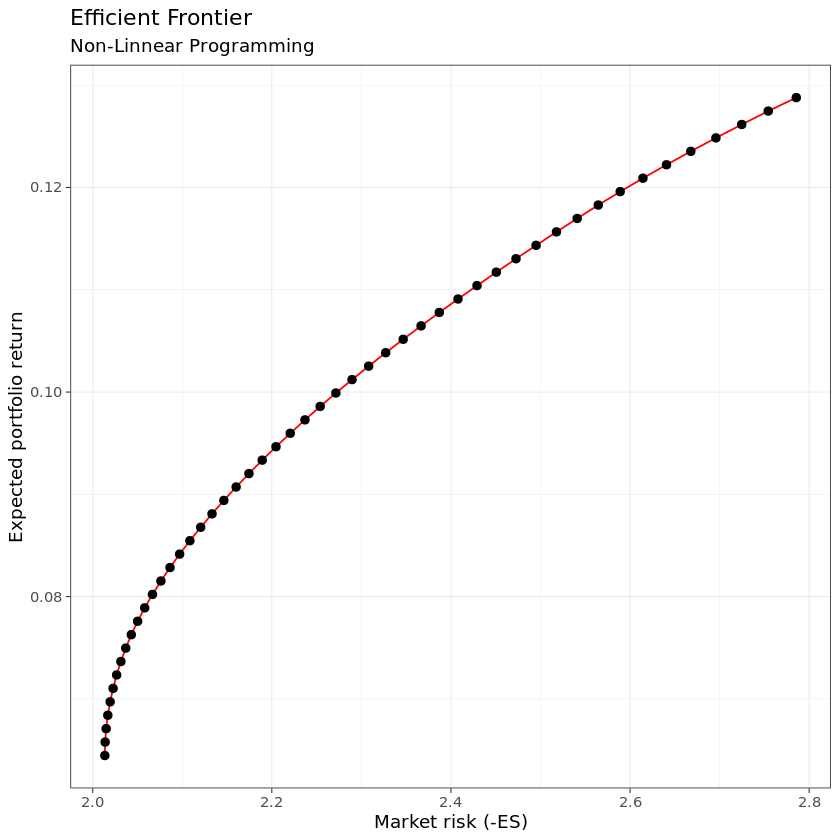

In [23]:
# Efficient Frontier plot
ES_EF <- ES
Er_EF <- ExpRet
wdf_NLP <- data.frame(w)
EFdf_NLP <- data.frame(matrix(c(-ES_EF,Er_EF),ncol = 2))
colnames(EFdf_NLP) <-  c("ES", "Er")

EFplot <- ggplot(EFdf_NLP,aes(x = ES, y = Er)) +
  geom_point(size=1, color="red") +
  geom_line(color="red")+
  geom_point(size=2)+
  labs(title = "Efficient Frontier",
       subtitle = "Non-Linnear Programming",
       #caption = " ",
       #tag = "Figure 1",
       x = "Market risk (-ES)",
       y = "Expected portfolio return")
EFplot + theme_bw(base_line_size = 0.3)

The Efficient Frontier illustrates the risk/return relationship, i.e., the higher the expected return, the higher the risk. Each dot represents a different portfolio. For instance, the first dot represents the expected return and market risk associated to the Global Minimum Risk portfolio, which is results from the following investment strategy:

In [24]:
# Global Minimum Risk portfolio
GMR <- wdf_NLP[1,]*100
colnames(GMR) <- names(retdf[,2:dd])
rownames(GMR) <- "weights"
print(GMR)

            AAPL          AMZN     MSFT         GOOGL    BRK.A      JPM
weights 21.74675 -9.540716e-14 7.643575 -1.053293e-15 65.61144 4.998239


The GMR portfolio would by given by investing the higher proportion of total wealth, e.g., approximately a 65.6%, in BRK.A, a 21.75% in APPL, a 7.65% in MSFT, a 5% in JPM, and nothing neither in AMZN nor GOOGL. According to this strategy, the expected shortfall with a coverage level of 5% and the expected portfolio return would be given by: 

In [25]:
GMR_EF <- data.frame(ES_EF[1],Er_EF[1])
colnames(GMR_EF) <- c("Expected shortfall (5%)","Expected Return")
rownames(GMR_EF) <- "GMR portfolio"
print(GMR_EF)

              Expected shortfall (5%) Expected Return
GMR portfolio               -2.013533      0.06446324


### References
* Aas, K., Czado, C., Frigessi, A., Bakken, H. (2009). Pair-copula constructions of multiple dependence. Insurance: Mathematics and Economics 44 (2), 182– 198.

* Hansen, B. (1994). Autoregressive Conditional Density Estimation. International Economic Review, 35(3), 705-730. doi:10.2307/2527081

* Rockafellar and Uryasev (2000). Optimization of conditional value-at-risk. Journal of Risk 3: 21-41.